## Robson de Oliveira Caldas - 1831134018

## 1 - Banco de dados

### Conjunto de LOGs de um servidor Web Apache2.

O objetivo é classificar os acessos como reais (feitos por humanos) e fake (feitos por bots), a fim de bloquear os fakes e reduzir o tráfego desnecessário no servidor.

Bots, spiders e outros rastreadores que acessam as páginas dinâmicas podem causar uso extensivo de recursos (memória e CPU). Isso pode levar a uma alta carga no servidor e atrasar o site legítimo. Existem ainda os bots maliciosos, que vasculham o servidor em busca de vulnerabilidades constantemente.


#### Multiplos arquivos de log

Os logs são armazenados no servidor em arquivos separados, aqui vamos juntar todos em um só arquivo para o processamento:

In [1]:
# import lib.merge_logs as merge
# merge.merge('log/access.log')

## 2 - Pré-processamento

#### Logs no arquivo 'access.log.all'. Criar um DataFrame Pandas:

In [2]:
"""
RCaldas Log Parser.
"""
import sys,os
import time
import re
import datetime
import pandas as pd
import numpy as np
import matplotlib as plt
from collections import Counter
%matplotlib inline

try:
    log = open('log/access.log.all')
except IOError:
    print(__doc__,"\nErro ao ler o arquivo de log.")
    sys.exit(1)

### Dataframe
df = []
### Acumulador de palavras do campo Agent
tags_total = []
### Acumulador de IPs de bot
ipsbot = []
### Acumulador de IPs de humanos
ipshum = []
### Regex para pegar os campos corretos de cada linha
regc = re.compile('^(?P<ip>\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}) .+'
                  ' \[(?P<time>[0-9]+/\S+:\d{2}:\d{2}:\d{2} .+)\] '
                  '\"(?P<met>\S+) (?P<urn>\S+) \S+\" (?P<code>\d+) '
                  '(?P<size>\d+) \"(?P<identd>[^\"]+)\" \"(?P<agent>[^\"]*)\"')

### Loop em cada linha do arquivo:
for line in log:
    try:
        ### Armazenar os dados capturados com o regex (IP, URN, Código HTTP, Tamanho):
        m = regc.match(line)
        ip, urn, code, size = m.group('ip', 'urn', 'code', 'size')
        
        ### Converter data e hora para formato datetime
        datahora = datetime.datetime.strptime(m.group('time'), '%d/%b/%Y:%H:%M:%S %z')
        
        ### Método já categorizado = GET: 0, POST: 1, OUTRO: 2
        if m.group('met') == 'GET': metodo = 0
        elif m.group('met') == 'POST': metodo = 1
        else: metodo = 2
        
        ### Tem algo no identd?
        if m.group('identd') == '-': identd = 0
        else: identd = 1
        
        ### Informaçoes do agente acumulando em 'tags_total'
        agent = m.group('agent')
        tags = []
        for i in agent.split():
            i = i.split('/')[0]
            i = i.strip(';/)(.,')
            tags.append(i)
            tags_total.append(i)

    except:
        ### print('Linha fora do padrão:\n', line)
        continue
        
    ### Alimentar o dataframe com os dados:
    df.append({'IP': ip, 'Data': datahora, 'Metodo': metodo, 'Request': urn, 
               'Code': code, 'Bytes': size, 'Identd': identd, 'Agent': agent})

log.close()
df = pd.DataFrame(df)

### Converter as colunas numéricas em inteiro:
df['Bytes'] = pd.to_numeric(df['Bytes'])
df['Code'] = pd.to_numeric(df['Code'])

### Preencher as colunas Bot e Humano
df['Bot'] = 0
df['Hum'] = 0

### Randomizar as posiçoes dos dados:
df = df.sample(frac=1).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17578 entries, 0 to 17577
Data columns (total 10 columns):
Agent      17578 non-null object
Bytes      17578 non-null int64
Code       17578 non-null int64
Data       17578 non-null datetime64[ns, UTC-03:00]
IP         17578 non-null object
Identd     17578 non-null int64
Metodo     17578 non-null int64
Request    17578 non-null object
Bot        17578 non-null int64
Hum        17578 non-null int64
dtypes: datetime64[ns, UTC-03:00](1), int64(6), object(3)
memory usage: 1.3+ MB


**Descrição das variáveis:**

- Agent   : informações do agente (browser) como versão, compatibilidades, sistema operacional...
- Bytes   : Tamanho em bytes da requisição inteira.
- Code    : Código HTTP recebido (200: OK, 404: Not Found, 301: Redirect ...)
- Data    : Data e hora do acesso.
- IP      : IP do cliente.
- Identd  : Campo de identificação, presente geralmente em acessos já iniciados, não no primeiro GET.
- Metodo  : Metodo da requisição (GET: 0, POST:1, OUTROS:2)
- Request : URN solicitado para o servidor (Ex: /wp-admin.php)

In [3]:
df.head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum
0,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,3008,200,2019-03-15 11:01:29-03:00,179.153.187.200,1,0,/wp-content/plugins/gallery-by-supsystic/src/G...,0,0
1,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5072,200,2019-03-18 14:28:26-03:00,189.19.59.77,1,0,/wp-content/plugins/gallery-by-supsystic/src/G...,0,0
2,Mozilla/5.0 (Windows NT 6.1; rv:52.0) Gecko/20...,4298,200,2019-03-18 01:06:45-03:00,59.21.169.153,0,1,/wp-login.php,0,0
3,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:59...,579,301,2019-04-03 09:56:07-03:00,118.24.58.56,0,1,/56.php,0,0
4,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,6458,200,2019-03-22 13:43:28-03:00,23.100.232.233,1,0,/wp-content/uploads/LL.jpg,0,0


## 3 - Análise da Distribuição

### a. Bytes e Request

Um acesso normal geralmente tem o tamanho de Bytes proporcional ao tamanho do campo Request, quando os Bytes são maiores desproporcionalmente significa que mais dados foram transferidos em outros campos diferentes do padrão, podendo ser um bot injetando dados em campos aleatórios para tentar descobrir vulnerabilidades.

Isso só se aplica quando o campo 'Identd' não está marcado, quano ele é marcado é comum os 'Bytes' serem maiores pois geralmente o cliente esta pedindo a transferencia de alguma imagem ou algum elemento do servidor.

Vamos analisar os campos 'Bytes' e 'Request' em relação ao 'Identd':

In [4]:
### Cria uma coluna com o tamanho do Request para comparar com os Bytes
req_Len = []
for i in df.Request.apply(len):
    req_Len.append(i)
df['rLen'] = req_Len

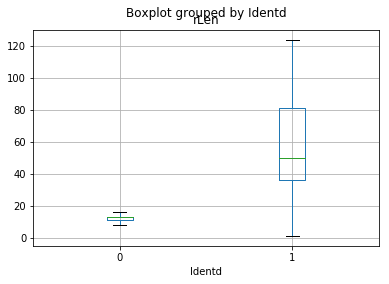

In [5]:
### Tamanho do Request por Identd, excluindo os outliers
df.boxplot(column='rLen', by = 'Identd', showfliers=False)

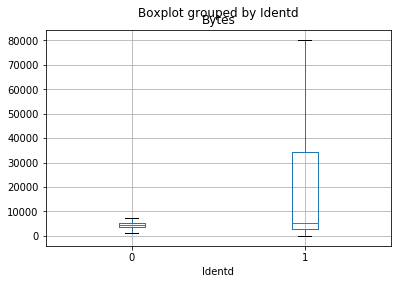

In [6]:
## Tamanho da requisição por Identd, excluindo os outliers
df.boxplot(column='Bytes', by = 'Identd', showfliers=False)

In [7]:
### Ver percentil dos requests
df['rLen'].describe()

count    17578.000000
mean        42.545853
std         36.540780
min          1.000000
25%         13.000000
50%         36.000000
75%         65.000000
max        534.000000
Name: rLen, dtype: float64

In [8]:
## Analisar os registros com Request maiores que 63 (75%) que não tenham Identd
df[(df['rLen']>=63) & (df['Identd']==0)].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
9,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,12287,200,2019-04-08 14:36:45-03:00,157.55.39.139,0,0,/wp-content/plugins/gallery-by-supsystic/src/G...,0,0,113
110,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...,726,301,2019-03-23 21:41:12-03:00,132.148.130.82,0,0,/wp-admin/admin-ajax.php?swp_debug=load_option...,0,0,89
183,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,10983,200,2019-03-16 19:04:38-03:00,157.55.39.108,0,0,/wp-content/plugins/gallery-by-supsystic/src/G...,0,0,116
222,Mozilla/5.0 (Linux; Android 5.0; SM-G900P Buil...,6900,200,2019-03-16 11:14:58-03:00,220.243.136.237,0,0,/wp-content/uploads/smile_fonts/Defaults/Defau...,0,0,63
303,Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build...,19025,200,2019-03-16 11:14:58-03:00,220.243.135.48,0,0,/wp-content/plugins/gallery-by-supsystic/src/G...,0,0,100


In [9]:
### Ver percentil dos Bytes
df['Bytes'].describe()

count    1.757800e+04
mean     1.783226e+04
std      4.662834e+04
min      0.000000e+00
25%      3.053000e+03
50%      4.752000e+03
75%      1.308900e+04
max      2.037909e+06
Name: Bytes, dtype: float64

In [10]:
### Analisar os registros com Request maiores que percentil de 75% que não tenham Identd
df[(df['Bytes']>=12645) & (df['Identd']==0)].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
28,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...,201950,200,2019-03-22 02:31:52-03:00,5.45.116.35,0,0,/,0,0,1
46,Mozilla/5.0 (Windows NT 6.1; rv:52.0) Gecko/20...,64211,404,2019-03-14 01:03:37-03:00,189.59.5.91,0,0,/?author=18,0,0,11
77,Mozilla/5.0 (iPhone; CPU iPhone OS 7_0 like Ma...,41850,200,2019-03-17 04:35:49-03:00,40.77.190.140,0,0,/wp-content/uploads/LLProj05-1-250x200.jpg,0,0,42
82,Mozilla/5.0 (iPhone; CPU iPhone OS 7_0 like Ma...,68080,200,2019-03-19 05:18:32-03:00,40.77.190.94,0,0,/wp-content/uploads/crk03-200x200.jpg,0,0,37
94,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,34322,200,2019-04-08 14:37:09-03:00,207.46.13.187,0,0,/wp-includes/js/jquery/jquery.js?ver=1.12.4,0,0,43


#### Marcar IPs de Bots identificáveis:

In [11]:
### Log com o 'Agent' estranho:
df.loc[df.Agent.str.contains('}__test|O:21:')].head(1)

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
659,}__test|O:21:\,3886,404,2019-04-03 08:12:48-03:00,94.23.255.34,0,0,/administrator/?1=%40ini_set%28%22display_erro...,0,0,325


In [12]:
### Ver os registros desse IP
df[df['IP']=="94.23.255.34"].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
134,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,3941,404,2019-04-03 08:14:11-03:00,94.23.255.34,1,0,//administrator//webconfig.txt.php,0,0,34
659,}__test|O:21:\,3886,404,2019-04-03 08:12:48-03:00,94.23.255.34,0,0,/administrator/?1=%40ini_set%28%22display_erro...,0,0,325
1747,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,608,301,2019-04-03 08:12:22-03:00,94.23.255.34,1,0,//webconfig.txt.php,0,0,19
2195,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,3947,404,2019-04-03 03:57:55-03:00,94.23.255.34,1,0,//administrator//webconfig.txt.php,0,0,34
3485,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,3932,404,2019-04-03 08:12:45-03:00,94.23.255.34,1,0,/wp-admin/admin-post.php?swp_debug=load_option...,0,0,112


Analizando o campo 'Request' dos logs desse IP podemos ver diversas tentativas de encontrar uma URN válida nos 'Requests'. Podemos marca-lo como Bot e fazer o mesmos para outros IPs:

In [13]:
### Guardar esse IP como bot
ipsbot.append('94.23.255.34')

In [14]:
### IP identificado com bytes altos e rLen pequeno.
df[df['IP']=="93.119.227.34"].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
2596,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,3537,301,2019-03-27 04:32:31-03:00,93.119.227.34,0,0,/,0,0,1
2806,Mozilla/5.0 (Linux; Android 7.0; SM-G930V Buil...,3383,421,2019-03-27 04:32:30-03:00,93.119.227.34,0,0,/,0,0,1
4255,Wget/1.13.4 (linux-gnu),202148,200,2019-03-27 04:32:31-03:00,93.119.227.34,0,0,/,0,0,1
6872,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,3383,421,2019-03-27 04:32:30-03:00,93.119.227.34,0,0,/,0,0,1
10363,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,202148,200,2019-03-27 04:32:32-03:00,93.119.227.34,0,0,/,0,0,1


Note que os bytes são muito grandes em alguns registros e o tamanho do 'Request' é apenas 1 ('/').

É possivel ver também que ele tenta o mesmo aceso com vários 'Agents' diferentes em intervalos de 1 segundo, Bot!

In [15]:
### Guardar esse IP como bot
ipsbot.append('93.119.227.34')

In [16]:
### Bot buscando pelo arquivo '/robots.txt'
ipsbot.append('54.149.94.16')
df[df['IP']=="54.149.94.16"].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
3712,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:55.0) ...,3820,404,2019-04-02 23:09:05-03:00,54.149.94.16,1,0,/robots.txt,0,0,11
6038,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:55.0) ...,594,301,2019-04-02 23:09:05-03:00,54.149.94.16,1,0,/robots.txt,0,0,11
6143,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,3980,200,2019-04-02 23:09:06-03:00,54.149.94.16,1,0,/,0,0,1
6485,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,574,301,2019-04-02 23:09:05-03:00,54.149.94.16,1,0,/,0,0,1
14273,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:55.0) ...,582,301,2019-04-02 23:09:04-03:00,54.149.94.16,1,0,/robots.txt,0,0,11


In [17]:
### Bot (spider) declarado no campo 'Agent'
ipsbot.append('13.53.136.118')
print(df[df['IP']=="13.53.136.118"]['Agent'].values)

['CheckMarkNetwork/1.0 (+http://www.checkmarknetwork.com/spider.html)'
 'CheckMarkNetwork/1.0 (+http://www.checkmarknetwork.com/spider.html)'
 'CheckMarkNetwork/1.0 (+http://www.checkmarknetwork.com/spider.html)'
 'CheckMarkNetwork/1.0 (+http://www.checkmarknetwork.com/spider.html)']


### b. Code e Método

Muitos GETs retornando 404 significa algum bot fazendo varredura por bruteforce.

Métodos POST em URNs que nao existem ou não aceitam POST também são Bots.

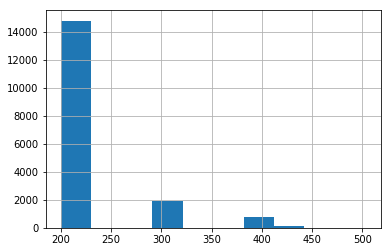

In [18]:
df['Code'].hist()

In [19]:
df['Code'].value_counts()

200    14797
301     1931
404      593
400      145
421       93
302        6
500        4
206        3
503        2
405        2
304        2
Name: Code, dtype: int64

### c. Agent

Analisar os Agents mais comuns

In [20]:
### Gerar a lista dos nomes mais usadas no campo 'Agent':
tagsorted = sorted([(value, key) for (key,value) in Counter(tags_total).items()], reverse=True)

topagents = [x[1] for x in tagsorted[:11]]
for top in topagents: print(top)

Mozilla
Gecko
Windows
NT
like
KHTML
AppleWebKit
Safari
Linux
Firefox
Chrome


In [21]:
## Filtro para explorar logs pelo campo 'Agent'
df.loc[(df['Agent'].str.contains('Mozilla')==False) & 
       (df['Agent'].str.contains('http')==False)  & 
       (df['Agent'].str.contains('Wget')==False),
       ['Agent','Request','IP']].head()

,Agent,Request,IP
138,-,/xmlrpc.php,192.190.85.14
308,Windows Live Writter,/xmlrpc.php,112.74.92.79
323,Windows Live Writter,/xmlrpc.php,159.89.201.166
409,Poster,/xmlrpc.php,67.23.253.155
415,-,/wp-admin/admin-ajax.php,39.104.205.49


In [22]:
### Bot tentando enviar parâmetros que não existem para a página wp-login.php
ipsbot.append('91.230.25.106')
df[df['IP']=="91.230.25.106"].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
5874,Opera/9.80 (Windows NT 6.2; Win64; x64) Presto...,496,302,2019-03-18 15:50:46-03:00,91.230.25.106,1,0,/wp-login.php?action=register,0,0,29
8494,Mozilla/5.0 (X11; Linux x86_64; rv:3.4) Goanna...,31133,200,2019-03-18 15:50:44-03:00,91.230.25.106,0,0,/,0,0,1
11312,Opera/9.80 (Windows NT 6.2; Win64; x64) Presto...,1756,200,2019-03-18 15:50:46-03:00,91.230.25.106,1,0,/wp-login.php?registration=disabled,0,0,35
13684,Mozilla/5.0 (X11; Linux x86_64; rv:3.4) Goanna...,583,301,2019-03-18 15:50:43-03:00,91.230.25.106,1,0,/,0,0,1


In [23]:
### Registros sem 'Agent' e 'Request' inexistente.
ipsbot.extend(['80.84.57.96', '80.84.57.101', '80.84.57.93'])
df[df['IP'].str.contains("80.84.57")].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
875,-,3586,404,2019-03-17 07:08:29-03:00,80.84.57.100,0,0,/cart/,0,0,6
3029,-,3583,404,2019-03-17 07:05:57-03:00,80.84.57.93,0,0,/store/,0,0,7
3704,-,539,301,2019-03-17 07:07:43-03:00,80.84.57.96,0,0,/store/,0,0,7
5077,-,549,301,2019-03-17 07:08:19-03:00,80.84.57.100,0,0,/shop/,0,0,6
5168,-,549,301,2019-03-17 07:08:29-03:00,80.84.57.100,0,0,/cart/,0,0,6


In [24]:
### Bot declarado no campo 'Agent'
ipsbot.extend(['118.24.58.56', '94.23.255.34', '40.77.167.172', '54.36.150.56',
              '13.53.136.118', '54.36.149.67','157.55.39.139', '66.249.64.56',
              '54.36.150.60', '54.36.148.198', '54.36.148.34', '54.36.148.33',
              '103.129.220.250', '138.197.68.2'])
df.loc[df['Agent'].str.contains('bot')].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
6,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,4855,200,2019-04-08 14:37:15-03:00,207.46.13.187,0,0,/wp-includes/js/wp-embed.min.js?ver=4.9.6,0,0,41
9,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,12287,200,2019-04-08 14:36:45-03:00,157.55.39.139,0,0,/wp-content/plugins/gallery-by-supsystic/src/G...,0,0,113
16,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,3698,404,2019-04-02 06:13:24-03:00,54.36.150.58,0,0,/manual/en/misc/index.html,0,0,26
35,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,4052,200,2019-03-25 02:44:33-03:00,157.55.39.21,0,0,/robots.txt,0,0,11
58,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,583,301,2019-03-13 03:40:02-03:00,66.249.66.218,0,0,/,0,0,1


In [25]:
# Agents reais (humanos) feitos de equipamentos conhecidos (LG-H870, SM-J500M, SM-J530G, j5lte...)
ipshum.extend(['191.39.11.138','179.153.187.200','189.40.76.184','200.130.16.5','45.56.114.108'])
df.loc[df['Agent'].str.contains('SM-J500M')].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
0,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,3008,200,2019-03-15 11:01:29-03:00,179.153.187.200,1,0,/wp-content/plugins/gallery-by-supsystic/src/G...,0,0,110
76,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,2258,200,2019-03-15 11:01:29-03:00,179.153.187.200,1,0,/wp-includes/js/jquery/ui/core.min.js?ver=1.11.4,0,0,48
115,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,20284,200,2019-03-15 11:01:33-03:00,179.153.187.200,1,0,/wp-content/uploads/LLbg333.jpg,0,0,31
116,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,7551,200,2019-03-15 11:01:27-03:00,179.153.187.200,1,0,/wp-content/plugins/revslider/public/assets/cs...,0,0,70
432,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,3774,200,2019-03-15 11:01:29-03:00,179.153.187.200,1,0,/wp-content/themes/jupiter/js/jquerytransit.js...,0,0,56


### d. IP


In [26]:
## Descobrir os IPs que mais aparecem 
df['IP'].value_counts().head()

23.100.232.233     1098
45.56.114.108       494
118.24.58.56        441
189.61.19.38        314
185.211.245.199     275
Name: IP, dtype: int64

In [27]:
## Ver os registros do IP que mais aparece
df[df['IP']==df['IP'].value_counts().head().keys()[0]].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
4,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,6458,200,2019-03-22 13:43:28-03:00,23.100.232.233,1,0,/wp-content/uploads/LL.jpg,0,0,26
21,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,42356,200,2019-03-20 13:30:51-03:00,23.100.232.233,1,0,/wp-content/uploads/cIMG_6391-200x200.jpg,0,0,41
44,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,53129,200,2019-03-22 13:43:34-03:00,23.100.232.233,1,0,/wp-content/uploads/LogoRedeTV-300x198.png,0,0,42
49,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,56729,200,2019-03-20 13:31:00-03:00,23.100.232.233,1,0,/wp-content/uploads/LLProj01-1-250x200.jpg,0,0,42
60,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,34355,200,2019-03-22 19:12:37-03:00,23.100.232.233,1,0,/wp-includes/js/jquery/jquery.js?ver=1.12.4,0,0,43


## 4 - Marcações

Vamos começar a marcar os registros como Bot ou Humano nas colunas do df:

In [28]:
### Marcar os bots reconhecidos
for ip in np.unique(ipsbot):
    df.loc[df.IP == ip, 'Bot'] = 1
df[df['Bot']==1].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
3,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:59...,579,301,2019-04-03 09:56:07-03:00,118.24.58.56,0,1,/56.php,1,0,7
9,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,12287,200,2019-04-08 14:36:45-03:00,157.55.39.139,0,0,/wp-content/plugins/gallery-by-supsystic/src/G...,1,0,113
31,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,603,301,2019-04-03 09:58:02-03:00,118.24.58.56,0,0,/phpadmin/index.php,1,0,19
40,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,629,301,2019-04-03 09:58:11-03:00,118.24.58.56,0,0,/phpMyAdmin/phpMyAdmin/index.php,1,0,32
134,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,3941,404,2019-04-03 08:14:11-03:00,94.23.255.34,1,0,//administrator//webconfig.txt.php,1,0,34


In [29]:
### Marcar acessos humanos
for ip in np.unique(ipshum):
    df.loc[df.IP == ip, 'Hum'] = 1
df[df['Hum']==1].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
0,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,3008,200,2019-03-15 11:01:29-03:00,179.153.187.200,1,0,/wp-content/plugins/gallery-by-supsystic/src/G...,0,1,110
20,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,61063,200,2019-04-08 15:04:33-03:00,200.130.16.5,1,0,/wp-content/uploads/br06-200x200.jpg,0,1,36
34,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,10983,200,2019-04-08 15:04:31-03:00,200.130.16.5,1,0,/wp-content/plugins/gallery-by-supsystic/src/G...,0,1,116
51,WordPress/4.9.6; https://llproducoes.com.br,3304,200,2019-03-20 15:57:34-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553108254.26984810...,0,1,60
76,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,2258,200,2019-03-15 11:01:29-03:00,179.153.187.200,1,0,/wp-includes/js/jquery/ui/core.min.js?ver=1.11.4,0,1,48


#### Para aumentar a quantidade de recursos vamos marcar os registros que possuem a palavra 'Mozilla' em 'Agent':

In [30]:
### Agents que contem 'Mozilla'
df['aMoz'] = (df['Agent'].str.contains('Mozilla')).astype(int)
df[df['aMoz']==1].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen,aMoz
0,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,3008,200,2019-03-15 11:01:29-03:00,179.153.187.200,1,0,/wp-content/plugins/gallery-by-supsystic/src/G...,0,1,110,1
1,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5072,200,2019-03-18 14:28:26-03:00,189.19.59.77,1,0,/wp-content/plugins/gallery-by-supsystic/src/G...,0,0,104,1
2,Mozilla/5.0 (Windows NT 6.1; rv:52.0) Gecko/20...,4298,200,2019-03-18 01:06:45-03:00,59.21.169.153,0,1,/wp-login.php,0,0,13,1
3,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:59...,579,301,2019-04-03 09:56:07-03:00,118.24.58.56,0,1,/56.php,1,0,7,1
4,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,6458,200,2019-03-22 13:43:28-03:00,23.100.232.233,1,0,/wp-content/uploads/LL.jpg,0,0,26,1


#### Vamos fazer o mesmo para 'http:' e 'WordPress':

In [31]:
### Agentes que contem 'http:'
df['aHttp'] = (df['Agent'].str.contains('https?:')).astype(int)
df[df['aHttp']==1].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen,aMoz,aHttp
6,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,4855,200,2019-04-08 14:37:15-03:00,207.46.13.187,0,0,/wp-includes/js/wp-embed.min.js?ver=4.9.6,0,0,41,1,1
9,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,12287,200,2019-04-08 14:36:45-03:00,157.55.39.139,0,0,/wp-content/plugins/gallery-by-supsystic/src/G...,1,0,113,1,1
16,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,3698,404,2019-04-02 06:13:24-03:00,54.36.150.58,0,0,/manual/en/misc/index.html,0,0,26,1,1
35,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,4052,200,2019-03-25 02:44:33-03:00,157.55.39.21,0,0,/robots.txt,0,0,11,1,1
51,WordPress/4.9.6; https://llproducoes.com.br,3304,200,2019-03-20 15:57:34-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553108254.26984810...,0,1,60,0,1


In [32]:
### Agentes que contem 'WordPress'
df['aWP'] = (df['Agent'].str.contains('WordPress')).astype(int)
df[df['aWP']==1].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen,aMoz,aHttp,aWP
51,WordPress/4.9.6; https://llproducoes.com.br,3304,200,2019-03-20 15:57:34-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553108254.26984810...,0,1,60,0,1,1
90,WordPress/4.9.6; https://llproducoes.com.br,3304,200,2019-03-20 23:52:55-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553136775.11895704...,0,1,60,0,1,1
96,WordPress/4.9.6; https://llproducoes.com.br,3304,200,2019-03-24 07:55:58-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553424958.44705390...,0,1,60,0,1,1
260,WordPress/4.9.6; https://llproducoes.com.br,3304,200,2019-03-25 18:50:08-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553550607.86846089...,0,1,60,0,1,1
295,WordPress/4.9.6; https://llproducoes.com.br,3304,200,2019-03-22 19:40:58-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553294457.82077193...,0,1,60,0,1,1


In [33]:
### Separar os dados rotulados:
df_rot = df[(df['Hum']==1) | (df['Bot']==1)].reset_index()
df_outros = df[(df['Hum']==0) & (df['Bot']==0)].reset_index()

## 5 - Classificação

#### Analisar com Random Forest 

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn import svm

def classifica(model, data, X, Y):
    start = time.time()
    model.fit(data[X],data[Y])
    print("Tempo de treinamento: ",time.time()-start)
    predict = model.predict(data[X])
    acuracia = metrics.accuracy_score(predict, data[Y])
    print("Acuracia: %s" % "{0:.3%}".format(acuracia))

    ### Faz validação cruzada com k-fold
    kf = KFold(n_splits=5)
    error = []
    for train, test in kf.split(data):
        # Filtra dados de treino 
        train_predictors = (data[X].iloc[train,:])

        # O alvo que estamos usando para treinar o algoritmo 
        train_target =  data[Y].iloc[train]

        # Treinando o algoritmo com previsores e alvo     
        model.fit(train_predictors, train_target)

        #Grava erros de cada loop de validação cruzada      
        error.append(model.score(data[X].iloc[test,:], data[Y].iloc[test]))

    print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))
    print("Tempo total: ",time.time()-start)
    
    #Acerta de novo o modelo para que possa se referir fora da função
    model.fit(data[X],data[Y])

### Escolher todas as caracteristicas numéricas e o alvo.
X = ['Bytes', 'Code', 'Identd', 'Metodo', 'rLen', 'aMoz', 'aHttp', 'aWP']
Y = 'Bot'

### Rodar Floresta Aleatória para tentar ver a importancia das caracteristicas.
model = RandomForestClassifier(n_estimators=1000)
classifica(model, df_rot, X, Y)

Tempo de treinamento:  0.6939005851745605
Acuracia: 100.000%
Cross-Validation Score : 99.200%
Tempo total:  4.431241989135742


Overfiting??

In [35]:
### Verificar a importancia de cada recurso
featimp = pd.Series(model.feature_importances_, index=X).sort_values(ascending=False)
print(featimp)

Identd    0.307252
Code      0.254239
rLen      0.207058
Bytes     0.143337
aWP       0.027086
aHttp     0.023660
Metodo    0.019295
aMoz      0.018075
dtype: float64


As características extraidas do campo Agent (aWP, aMoz e aHttp) não parecem ser importantes, melhorar a extraçao de recursos.

Dividir os dados em treino e teste:

In [36]:
#! Aprender a usar: sklearn.model_selection.train_test_split

### Definir o tamanho do treino/teste:
treino = int(0.9 * len(df_rot[Y]))
teste = len(df_rot[Y])-treino

### Separar treino e teste:
treiX = df_rot.iloc[:treino][X].values
treiY = df_rot[:treino][Y].values
testX = df_rot[-teste:][X].values
testY = df_rot[-teste:][Y].values

Utilizar PCA?

### MLP

In [44]:
### Definir MLP
mlp = MLPClassifier(hidden_layer_sizes=(30,),activation='relu', max_iter=1000,verbose=10)

def treinar(model):
    start = time.time()
    model.fit(treiX, treiY)
    print("Tempo de treinamento: ",time.time()-start)

treinar(mlp)
print('Erro do treinamento: ',mlp.loss_)

Iteration 1, loss = 13.97266381
Iteration 2, loss = 13.97266377
Iteration 3, loss = 13.97266372
Iteration 4, loss = 13.95880087
Iteration 5, loss = 9.34623763
Iteration 6, loss = 7.36419419
Iteration 7, loss = 9.04266504
Iteration 8, loss = 8.72106210
Iteration 9, loss = 6.31066820
Iteration 10, loss = 2.84560420
Iteration 11, loss = 1.80948630
Iteration 12, loss = 1.82567987
Iteration 13, loss = 1.81307261
Iteration 14, loss = 1.79162454
Iteration 15, loss = 1.76507359
Iteration 16, loss = 1.66950835
Iteration 17, loss = 1.23578909
Iteration 18, loss = 1.54157973
Iteration 19, loss = 1.62269688
Iteration 20, loss = 0.93701712
Iteration 21, loss = 1.05080590
Iteration 22, loss = 0.90674900
Iteration 23, loss = 1.16891817
Iteration 24, loss = 0.97061275
Iteration 25, loss = 1.16887453
Iteration 26, loss = 0.93827615
Iteration 27, loss = 1.28736748
Iteration 28, loss = 0.86220625
Iteration 29, loss = 1.27545752
Iteration 30, loss = 0.85103939
Iteration 31, loss = 0.82826676
Iteration 32,

Com 30 no tamanho da camada oculta foi como consegui o menor erro.

Mas o erro ainda tá muito grande!

Preciso gerar mais dados rotulados, principalmente de acessos Humanos que são poucos ainda

Vamos ver as métricas mesmo assim:

In [45]:
### Métricas da validacão MLP
def metricas(testPred):
    acertos = 0

    for i in range(0, len(testY)):
        if testPred[i] == testY[i]:
            acertos += 1
    print('Número de acertos: ' + str((acertos*100)/len(testY)))
    print('Matriz de Confusão: \n',confusion_matrix(testY,testPred))
    print(classification_report(testY,testPred))

metricas(mlp.predict(testX))

Número de acertos: 90.0
Matriz de Confusão: 
 [[88 11]
 [ 4 47]]
              precision    recall  f1-score   support

           0       0.96      0.89      0.92        99
           1       0.81      0.92      0.86        51

   micro avg       0.90      0.90      0.90       150
   macro avg       0.88      0.91      0.89       150
weighted avg       0.91      0.90      0.90       150



### SVM

In [46]:
### Definir SVM
svm_ = svm.SVC(kernel='rbf',C =1, gamma='auto')

treinar(svm_)

Tempo de treinamento:  0.019001245498657227


In [47]:
### Métricas da validacão SVM
metricas(svm_.predict(testX))


Número de acertos: 95.33333333333333
Matriz de Confusão: 
 [[99  0]
 [ 7 44]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        99
           1       1.00      0.86      0.93        51

   micro avg       0.95      0.95      0.95       150
   macro avg       0.97      0.93      0.95       150
weighted avg       0.96      0.95      0.95       150



## 9 - Futuras Implementações

- Verificar se o request solicitado existe no servidor, se não tiver atribuir grande peso para classificar como bot.
- Identificar e registrar o intervalo em segundos entre um acesos e outro do mesmo IP para melhor identificar bots.
- Pegar GeoIP Country name de cada IP
- Incluir na leitura dos logs, talvez com javascript, informaçoes de movimento do mouse na página para melhor identificar bots.


## Projeto Final

- Escolher um banco de dados de qualquer natureza (imagem, série temporal, dados de comércio, dados bancários, etc); https://toolbox.google.com/datasetsearch
- Fazer pré-processamento (se necessário);
- Extração de características (PCA, filtros digitais, etc);
- Classificação com um dos algoritmos estudado: PCA, K_means, MLP, SVM, BOOSTING, REGRESSÃO LOGÍSTICA, CNN, RNN e GAN.
- Usar validação cruzada para separar dados de treino e validação e matriz de confusão para cálculo das métricas.

### IMPORTANTÍSSIMO:

- Contextualizar sua classificação, qual o problema a ser solucionado com os seus resultados?
- Levantar as dificuldades, limitações, inconsistências e imprecisões nas soluções propostas.
- Sugerir futuras implementações.
- Para o seu banco de dados existem outros trabalhos de classificação na literatura? (site para pesquisa: https://sci-hub.tw/)


#### Rascunho

In [41]:
# df[df['model'].str.match('Mac')]
# df1 = df[df['Team'].str.contains("Boston") | df['College'].str.contains('MIT')] 
# df[df['Request'].str.contains(r'^/[^/]+.php$')]


In [42]:
# df['new column name'] = df['df column_name'].apply(lambda x: 'value if condition is met' if x condition else 'value if condition is not met')
# df.loc[(df.First_name == 'Bill') | (df.First_name == 'Emma'), 'name_match'] = 'Match'  

# row['Hum'] = [1 for x in row['IP'] if x == ip ]
# df['color'] = df.Set.map( lambda x: 'red' if x == 'Z' else 'green')

#################################

### The two more common referer domains from the total referers
# domains = referers.str.extract(r'^(https?://)?(www.)?([^/]*)')[2].str.lower()
# domains.value_counts()[:2].divide(domains.count())

#################################

### Transforma cada Code em uma nova coluna marcando 0 ou 1
# for i in df.Code.unique():
#     df[i]=(df.Code==i).astype(int)
# df

######

# data = pd.read_clipboard(sep=',')

# #get the names of the first 3 columns
# colN = data.columns.values[:3]

# #make a copy of the dataframe
# data_transformed = data

# #the get_dummies method is doing the job for you
# for column_name in colN:
#     dummies = pd.get_dummies(data_transformed[column_name], prefix='value', prefix_sep='_')
#     col_names_dummies = dummies.columns.values

#     #then you can append new columns to the dataframe
#     for i,value in enumerate(col_names_dummies):
#         data_transformed[value] = dummies.iloc[:,i]

##################################

# sorted(Counter(tags).items(), key=lambda x: x[1])
#     print(re.match(regex, line))
#     if re.search('^189.', line):
#         print(line+'\n')

#     ip = re.findall('^([0-9]+.[0-9]+.[0-9]+.[0-9]+) ', line)
# regex = '([(\d\.)]+) - - \[(.*?)\] "(.*?)" (\d+) - "(.*?)" "(.*?)"'
# regex = '([(\d\.)]+) - - \[(.*?)\] "(.*?)" (\d+)'

## Começa e termina com caractere comum, continua com nao espaços:
# [a-zA-Z0-9]\S*@\S*[a-zA-Z] 

# map(''.join, re.findall(r'\"(.*?)\"|\[(.*?)\]|(\S+)', row))